In [2]:
import pandas as pd
import numpy as np

**On regroupe tous les 200 scrutins**

In [3]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)

In [4]:
df_votes['Pour'] = np.where(df_votes['vote']== 'Pour', 1, 0)
df_votes['Contre'] = np.where(df_votes['vote']== 'Contre', 1, 0)
df_votes['Non-votant'] = np.where(df_votes['vote']== 'Non-votant', 1, 0)

On crée des listes contenants 200 scrutins par ordre chronologique 

In [5]:
df_scrutins = df_votes.sort_values(['date_scrutin'])[['idScrutin','date_scrutin']]
df_scrutins = df_scrutins.drop_duplicates()
df_copy = df_scrutins.copy()

In [6]:
dates = []
namespace = globals()
for x in range(1,16):
    namespace['scrutins_%d' % x] = list(df_copy.head(200)['idScrutin'])
    dates.append(df_copy.iloc[0]['date_scrutin'])
    dates.append(df_copy.iloc[199]['date_scrutin'])
    df_copy = df_copy[~df_copy['idScrutin'].isin(namespace['scrutins_%d' % x])]
    
namespace['scrutins_%d' % 16] = list(df_copy['idScrutin'])
dates.append(df_copy.iloc[0]['date_scrutin'])
dates.append(df_copy.iloc[116]['date_scrutin'])
df_copy = df_copy[~df_copy['idScrutin'].isin(namespace['scrutins_%d' % 16])]

In [7]:
df_copy
#on a bien utilisé tout le DF

,idScrutin,date_scrutin


In [8]:
len(scrutins_16)
#la dernière liste de scrutin est plus courte (mais seulement de 3 scrutins, ça reste raisonnable sur 200)

117

On crée les dataframes complets correspondant à ces listes de scrutins

In [9]:
for x in range(1,17):
    namespace['df_scrutins_%d' % x] = df_votes[df_votes['idScrutin'].isin(namespace['scrutins_%d' % x])]

On calcule l'indice accord de chaque votant avec son parti sur chaque data frame 

In [10]:
def accord_parti_200 (df_scrutins_x):
    df_grouped = df_scrutins_x[['vote', 'Pour', 'Contre', 'Non-votant', 'idScrutin', 'Groupe politique (complet)']].groupby(['Groupe politique (complet)', 'idScrutin']).sum()
    df_grouped = df_grouped.assign(vote_maj_parti=df_grouped.idxmax(1))
    df_grouped = df_grouped.drop(['Pour', 'Contre', 'Non-votant'], axis =1)
    df_scrutins_x2 = df_scrutins_x.merge(df_grouped, on=['Groupe politique (complet)', 'idScrutin'], how='left')
    df3= df_scrutins_x2[((df_scrutins_x2.vote == 'Pour') & (df_scrutins_x2.vote_maj_parti == 'Pour')) | ((df_scrutins_x2.vote == 'Contre') & (df_scrutins_x2.vote_maj_parti == 'Contre')) | ((df_scrutins_x2.vote == 'Non-votant') & (df_scrutins_x2.vote_maj_parti == 'Non-votant'))]

    Accord_votant = df3.idVotant.value_counts() 
    Total_votant = df_scrutins_x2.idVotant.value_counts()

    IndiceAccordParti=[]
    
    Votants2=df3['idVotant'].unique()

    for votant in Votants2:     
        IndiceAccordParti.append(int(Accord_votant[votant])/int(Total_votant[votant])*100)
    
    IndiceAccordPartiDF = pd.DataFrame({'idVotant' : Votants2,
                               'IndiceAccordParti' : IndiceAccordParti})
    return (IndiceAccordPartiDF)

In [11]:
liste = []
for x in range(1,17):
    namespace['indice_%d' % x] = accord_parti_200(namespace['df_scrutins_%d' % x])
    namespace['indice_%d' % x] = namespace['indice_%d' % x].rename(columns = {'IndiceAccordParti' : 'indice_accord_%d' % x})
    df_votes = df_votes.merge(namespace['indice_%d' % x], on = 'idVotant')
    liste.append('indice_accord_%d' % x)

In [12]:
# WARNING 290496 rows au début vs 289441 rows mnt 

In [13]:
df_accord_200 = df_votes[['idVotant', 'Groupe politique (complet)','indice_accord_1', 'indice_accord_2', 'indice_accord_3', 'indice_accord_4', 'indice_accord_5', 'indice_accord_6', 'indice_accord_7', 'indice_accord_8',
     'indice_accord_9','indice_accord_10','indice_accord_11','indice_accord_12','indice_accord_13','indice_accord_14','indice_accord_15','indice_accord_16']].drop_duplicates()

In [14]:
df_accord_200 = df_accord_200.set_index('idVotant')
df_accord_200
#549 députés ?????? 

,Groupe politique (complet),indice_accord_1,indice_accord_2,indice_accord_3,indice_accord_4,indice_accord_5,indice_accord_6,indice_accord_7,indice_accord_8,indice_accord_9,indice_accord_10,indice_accord_11,indice_accord_12,indice_accord_13,indice_accord_14,indice_accord_15,indice_accord_16
idVotant,,,,,,,,,,,,,,,,,
PA606171,La République en Marche,43.157895,34.831461,30.275229,27.631579,35.897436,39.735099,20.000000,24.855491,18.493151,25.465839,28.654971,23.125000,20.382166,27.380952,25.153374,20.408163
PA721824,La République en Marche,62.820513,34.146341,43.103448,23.684211,39.024390,59.523810,30.434783,31.914894,23.214286,32.608696,24.444444,24.074074,46.153846,37.735849,38.461538,59.259259
PA719952,La République en Marche,100.000000,98.387097,98.245614,100.000000,97.142857,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,97.142857,100.000000,100.000000,100.000000,100.000000
PA607395,La République en Marche,88.888889,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,92.857143,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
PA718710,La République en Marche,97.647059,94.666667,97.530864,100.000000,100.000000,96.296296,100.000000,97.826087,93.442623,100.000000,95.081967,100.000000,98.360656,95.384615,95.652174,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA720038,Mouvement Démocrate (MoDem) et Démocrates appa...,94.285714,87.500000,66.666667,90.000000,85.000000,90.000000,81.818182,100.000000,92.307692,90.909091,83.333333,77.777778,92.857143,73.333333,85.714286,93.750000
PA722358,Agir ensemble,81.481481,90.000000,91.428571,92.307692,100.000000,100.000000,95.238095,90.909091,89.473684,100.000000,85.714286,100.000000,88.888889,95.238095,100.000000,100.000000
PA610654,Gauche démocrate et républicaine,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [15]:
df_accord_200 = df_accord_200.drop('Groupe politique (complet)', axis =1)
df_accord_200_T = df_accord_200.transpose()

In [16]:
#On normalise les données 


#df_accord = df_accord.drop('cluster', axis =1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_accord_200_T)
df = pd.DataFrame(scaler.transform(df_accord_200_T), columns = df_accord_200_T.columns, index = df_accord_200_T.index)

df_stand = df.T

df_stand 

,indice_accord_1,indice_accord_2,indice_accord_3,indice_accord_4,indice_accord_5,indice_accord_6,indice_accord_7,indice_accord_8,indice_accord_9,indice_accord_10,indice_accord_11,indice_accord_12,indice_accord_13,indice_accord_14,indice_accord_15,indice_accord_16
idVotant,,,,,,,,,,,,,,,,
PA606171,2.165591,0.988391,0.344226,-0.029536,1.139100,1.681672,-1.108496,-0.422022,-1.321536,-0.335730,0.115152,-0.666680,-1.054465,-0.064970,-0.379907,-1.050790
PA721824,1.947788,-0.317270,0.390279,-1.143705,0.068062,1.687371,-0.610457,-0.493539,-1.180825,-0.438733,-1.083651,-1.112908,0.631238,-0.033724,0.023600,1.666474
PA719952,0.553078,-1.018563,-1.156426,0.553078,-2.230972,0.553078,0.553078,0.553078,0.553078,0.553078,0.553078,-2.230972,0.553078,0.553078,0.553078,0.553078
PA607395,-3.217339,0.368153,0.368153,0.368153,0.368153,0.368153,0.368153,0.368153,-1.936806,0.368153,0.368153,0.368153,0.368153,0.368153,0.368153,0.368153
PA718710,0.013148,-1.338249,-0.039538,1.080039,1.080039,-0.599327,1.080039,0.094324,-1.893266,1.080039,-1.149940,1.080039,0.336713,-1.012710,-0.891391,1.080039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA720038,0.932933,0.111563,-2.410186,0.414173,-0.191047,0.414173,-0.576187,1.624612,0.693505,0.524213,-0.392787,-1.065253,0.760013,-1.603226,-0.104587,0.868088
PA722358,-2.148401,-0.661830,-0.412529,-0.259113,1.083275,1.083275,0.252273,-0.503184,-0.753677,1.083275,-1.409732,1.083275,-0.855730,0.252273,1.083275,1.083275
PA610654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
#df_stand = df_stand.drop('cluster', axis =1)
#from tslearn.clustering import TimeSeriesKMeans
#from yellowbrick.cluster import KElbowVisualizer

#liste_metrics = ['distortion', 'calinski_harabasz', 'silhouette']
#on teste la règle du coude avec trois métriques différentes : 
# distorsion = somme au carré des distances de chaque point à son centroïde
# calinski_harabasz = ratio entre la dispersion entre clusters et la dispersion dans le cluster
# silhouette = moyenne du ratio entre la distance au centroïde de son cluster et la distance au centroïde le plus proche

#i=1
#for metric in liste_metrics:
#    model = TimeSeriesKMeans()
#    visualizer = KElbowVisualizer(model, k=(2,15), metric=metric) 
#    visualizer.fit(df_stand)       
#    visualizer.show() 
#i=+1

In [18]:
#On réalise le clustering 


#df_stand = df_stand.drop('cluster', axis =1)
import statistics
import tslearn
from tslearn.clustering import TimeSeriesKMeans


model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
Fit = model.fit(df_stand)

pred = Fit.labels_
df_stand['cluster'] = pred

df_cluster = df_stand

/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [19]:
df_cluster_0 = df_cluster[df_cluster['cluster'].isin(['0'])]
df_cluster_1 = df_cluster[df_cluster['cluster'].isin(['1'])]
df_cluster_2 = df_cluster[df_cluster['cluster'].isin(['2'])]
#df_cluster_3 = df_cluster[df_cluster['cluster'].isin(['3'])]

In [20]:
#tot 549

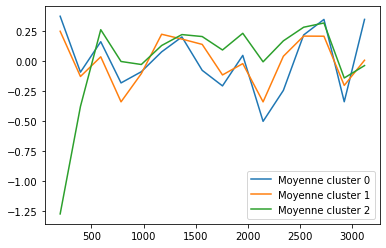

In [21]:
import matplotlib.pyplot as plt
import numpy as np

mean0 = []
for i in range(16):
    mean0.append(df_cluster_0[df_cluster_0.columns[i]].mean())
mean1 = []
for i in range(16):
    mean1.append(df_cluster_1[df_cluster_1.columns[i]].mean())
    
mean2 = []
for i in range(16):
    mean2.append(df_cluster_2[df_cluster_2.columns[i]].mean())
    
#mean3 = []
#for i in range(16):
#    mean3.append(df_cluster_3[df_cluster_3.columns[i]].mean())
    



x = np.linspace(200, 3117, 16)
plt.plot(x, mean0)
plt.plot(x, mean1)
plt.plot(x, mean2)
#plt.plot(x, mean3)
label = ['Moyenne cluster 0', 'Moyenne cluster 1','Moyenne cluster 2','Moyenne cluster 3']
plt.legend(labels = label)

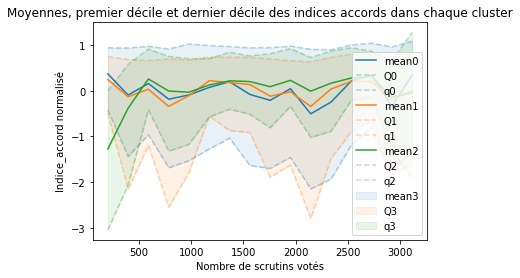

In [22]:
mean0 = []
for i in range(16):
    mean0.append(df_cluster_0[df_cluster_0.columns[i]].mean())
    
Q0 = []
for i in range(16):
    Q0.append(df_cluster_0[df_cluster_0.columns[i]].quantile(0.9))
    
q0 = []
for i in range(16):
    q0.append(df_cluster_0[df_cluster_0.columns[i]].quantile(0.1))
    
    
x = np.linspace(200, 3117, 16)
plt.plot(x, mean0, color = 'tab:blue')
plt.plot(x, Q0, color = 'tab:blue', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q0, color = 'tab:blue',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q0, q0, color='tab:blue',alpha=0.1) 



mean1 = []
for i in range(16):
    mean1.append(df_cluster_1[df_cluster_1.columns[i]].mean())
    
Q1 = []
for i in range(16):
    Q1.append(df_cluster_1[df_cluster_1.columns[i]].quantile(0.9))
    
q1 = []
for i in range(16):
    q1.append(df_cluster_1[df_cluster_1.columns[i]].quantile(0.1))
    
    
x = np.linspace(200, 3117, 16)
plt.plot(x, mean1, color = 'tab:orange')
plt.plot(x, Q1, color = 'tab:orange', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q1, color = 'tab:orange',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q1, q1, color='tab:orange',alpha=0.1) 




mean2 = []
for i in range(16):
    mean2.append(df_cluster_2[df_cluster_2.columns[i]].mean())
    
Q2 = []
for i in range(16):
    Q2.append(df_cluster_2[df_cluster_2.columns[i]].quantile(0.9))
    
q2 = []
for i in range(16):
    q2.append(df_cluster_2[df_cluster_2.columns[i]].quantile(0.1))
    
    
x = np.linspace(200, 3117, 16)
plt.plot(x, mean2, color = 'tab:green')
plt.plot(x, Q2, color = 'tab:green', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q2, color = 'tab:green',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q2, q2, color='tab:green',alpha=0.1) 


#mean3 = []
#for i in range(16):
#    mean3.append(df_cluster_3[df_cluster_3.columns[i]].mean())
    
#Q3 = []
#for i in range(16):
#    Q3.append(df_cluster_3[df_cluster_3.columns[i]].quantile(0.9))
    
#q3 = []
#for i in range(16):
#    q3.append(df_cluster_3[df_cluster_3.columns[i]].quantile(0.1))
    
    
#x = np.linspace(200, 3117, 16)
#plt.plot(x, mean3, color = 'tab:red')
#plt.plot(x, Q3, color = 'tab:red', linestyle = 'dashed', alpha = 0.3)
#plt.plot(x, q3, color = 'tab:red',linestyle = 'dashed', alpha = 0.3)
#plt.fill_between(x, Q3, q3, color='tab:red',alpha=0.1) 

plt.title("Moyennes, premier décile et dernier décile des indices accords dans chaque cluster")
plt.xlabel("Nombre de scrutins votés")
plt.ylabel("Indice_accord normalisé")


label = ['mean0', 'Q0','q0','mean1', 'Q1','q1', 'mean2', 'Q2','q2','mean3', 'Q3','q3']
plt.legend(labels = label)


On veut un graph en fonction du temps et pas en fonction du nombre de scrutins 

On a récupéré la liste avec les dates du premier et du dernier scrutin de chaque calcul d'indice. 
Deux solutions : 
- On calcule le milieu de chaque intervalle. On associe à cette nouvelle date l'indice calculé sur cet intervalle et on trace la courbe à partir de ça.
- On fait une fonction continue par morceaux. 

In [23]:
import datetime
from datetime import timedelta

mid_dates = []

for i in range(0,len(dates),2):
    start_date = datetime.datetime.strptime(dates[i],'%Y-%m-%d')
    end_date = datetime.datetime.strptime(dates[i+1],'%Y-%m-%d')
    difference_in_days = abs((end_date - start_date).days)
    mid_date = start_date + timedelta(difference_in_days/2)
    mid_dates.append(mid_date)
    

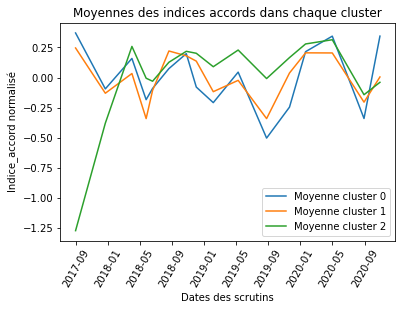

In [24]:
mean0 = []
for i in range(16):
    mean0.append(df_cluster_0[df_cluster_0.columns[i]].mean())
mean1 = []
for i in range(16):
    mean1.append(df_cluster_1[df_cluster_1.columns[i]].mean())
    
mean2 = []
for i in range(16):
    mean2.append(df_cluster_2[df_cluster_2.columns[i]].mean())
    
#mean3 = []
#for i in range(16):
#    mean3.append(df_cluster_3[df_cluster_3.columns[i]].mean())


x = mid_dates
plt.plot(x, mean0)
plt.plot(x, mean1)
plt.plot(x, mean2)
#plt.plot(x, mean3)


plt.title("Moyennes des indices accords dans chaque cluster")
plt.xlabel("Dates des scrutins")
plt.ylabel("Indice_accord normalisé")
for label in plt.gca().xaxis.get_ticklabels():
    label.set_rotation(60)
    
label = ['Moyenne cluster 0', 'Moyenne cluster 1','Moyenne cluster 2','Moyenne cluster 3']
plt.legend(labels = label)

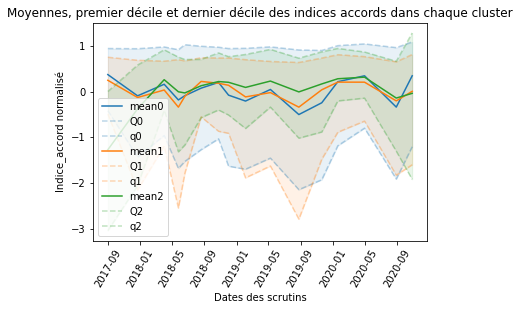

In [25]:
mean0 = []
for i in range(16):
    mean0.append(df_cluster_0[df_cluster_0.columns[i]].mean())
    
Q0 = []
for i in range(16):
    Q0.append(df_cluster_0[df_cluster_0.columns[i]].quantile(0.9))
    
q0 = []
for i in range(16):
    q0.append(df_cluster_0[df_cluster_0.columns[i]].quantile(0.1))
    
    
x = mid_dates
plt.plot(x, mean0, color = 'tab:blue')
plt.plot(x, Q0, color = 'tab:blue', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q0, color = 'tab:blue',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q0, q0, color='tab:blue',alpha=0.1) 



mean1 = []
for i in range(16):
    mean1.append(df_cluster_1[df_cluster_1.columns[i]].mean())
    
Q1 = []
for i in range(16):
    Q1.append(df_cluster_1[df_cluster_1.columns[i]].quantile(0.9))
    
q1 = []
for i in range(16):
    q1.append(df_cluster_1[df_cluster_1.columns[i]].quantile(0.1))
    
    
x = mid_dates
plt.plot(x, mean1, color = 'tab:orange')
plt.plot(x, Q1, color = 'tab:orange', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q1, color = 'tab:orange',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q1, q1, color='tab:orange',alpha=0.1) 




mean2 = []
for i in range(16):
    mean2.append(df_cluster_2[df_cluster_2.columns[i]].mean())
    
Q2 = []
for i in range(16):
    Q2.append(df_cluster_2[df_cluster_2.columns[i]].quantile(0.9))
    
q2 = []
for i in range(16):
    q2.append(df_cluster_2[df_cluster_2.columns[i]].quantile(0.1))
    
    
x = mid_dates
plt.plot(x, mean2, color = 'tab:green')
plt.plot(x, Q2, color = 'tab:green', linestyle = 'dashed', alpha = 0.3)
plt.plot(x, q2, color = 'tab:green',linestyle = 'dashed', alpha = 0.3)
plt.fill_between(x, Q2, q2, color='tab:green',alpha=0.1) 


#mean3 = []
#for i in range(16):
#    mean3.append(df_cluster_3[df_cluster_3.columns[i]].mean())
    
#Q3 = []
#for i in range(16):
#    Q3.append(df_cluster_3[df_cluster_3.columns[i]].quantile(0.9))
    
#q3 = []
#for i in range(16):
#    q3.append(df_cluster_3[df_cluster_3.columns[i]].quantile(0.1))
    
    
#x = mid_dates
#plt.plot(x, mean3, color = 'tab:red')
#plt.plot(x, Q3, color = 'tab:red', linestyle = 'dashed', alpha = 0.3)
#plt.plot(x, q3, color = 'tab:red',linestyle = 'dashed', alpha = 0.3)
#plt.fill_between(x, Q3, q3, color='tab:red',alpha=0.1) 

plt.title("Moyennes, premier décile et dernier décile des indices accords dans chaque cluster")
plt.xlabel("Dates des scrutins")
plt.ylabel("Indice_accord normalisé")
for label in plt.gca().xaxis.get_ticklabels():
    label.set_rotation(60)

label = ['mean0', 'Q0','q0','mean1', 'Q1','q1', 'mean2', 'Q2','q2']
plt.legend(labels = label)


**On fait par années**

In [35]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)

In [36]:
df_votes['Pour'] = np.where(df_votes['vote']== 'Pour', 1, 0)
df_votes['Contre'] = np.where(df_votes['vote']== 'Contre', 1, 0)
df_votes['Non-votant'] = np.where(df_votes['vote']== 'Non-votant', 1, 0)

In [4]:
df_votes[df_votes['date_scrutin'].str.startswith('2020')].groupby('idScrutin').count() #701 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2019')].groupby('idScrutin').count() #804 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2018')].groupby('idScrutin').count() #1255 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2017')].groupby('idScrutin').count() #357 scrutins

,idVotant,vote,organeRefGroupe,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,...,Profession,Groupe politique (complet),Groupe politique (abrégé),date_naissance,type_mandat,type_organe,qualite_mandat,Pour,Contre,Non-votant
idScrutin,,,,,,,,,,,,,,,,,,,,,
3,97,97,97,97,97,97,97,97,97,97,...,97,97,97,8,8,8,8,97,97,97
13,74,74,74,74,74,74,74,74,74,74,...,74,74,74,8,8,8,8,74,74,74
14,85,85,85,85,85,85,85,85,85,85,...,84,85,85,4,4,4,4,85,85,85
22,126,126,126,126,126,126,126,126,126,126,...,125,126,126,7,7,7,7,126,126,126
33,156,156,156,156,156,156,156,156,156,156,...,155,156,156,13,13,13,13,156,156,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,50,50,50,50,50,50,50,50,50,50,...,48,50,50,7,7,7,7,50,50,50
3102,396,396,396,396,396,396,396,396,396,396,...,392,396,396,75,75,75,75,396,396,396
3110,77,77,77,77,77,77,77,77,77,77,...,77,77,77,8,8,8,8,77,77,77


In [5]:
df_2020 = df_votes[df_votes['date_scrutin'].str.startswith('2020')]
df_2019 = df_votes[df_votes['date_scrutin'].str.startswith('2019')]
df_2018 = df_votes[df_votes['date_scrutin'].str.startswith('2018')]
df_2017 = df_votes[df_votes['date_scrutin'].str.startswith('2017')]

In [6]:
def accord_parti_annee (df_votes):
    df_grouped = df_votes[['vote', 'Pour', 'Contre', 'Non-votant', 'idScrutin', 'Groupe politique (complet)']].groupby(['Groupe politique (complet)', 'idScrutin']).sum()
    df_grouped = df_grouped.assign(vote_maj_parti=df_grouped.idxmax(1))
    df_grouped = df_grouped.drop(['Pour', 'Contre', 'Non-votant'], axis =1)
    df_votes2 = df_votes.merge(df_grouped, on=['Groupe politique (complet)', 'idScrutin'], how='left')
    Partis = pd.DataFrame(df_votes2.groupby('idVotant')['Groupe politique (complet)'].unique())
    df3= df_votes2[((df_votes2.vote == 'Pour') & (df_votes2.vote_maj_parti == 'Pour')) | ((df_votes2.vote == 'Contre') & (df_votes2.vote_maj_parti == 'Contre')) | ((df_votes2.vote == 'Non-votant') & (df_votes2.vote_maj_parti == 'Non-votant'))]

    Accord_votant = df3.idVotant.value_counts() 
    Total_votant = df_votes2.idVotant.value_counts()

    IndiceAccordParti=[]
    
    Votants2=df3['idVotant'].unique()

    for votant in Votants2:     
        IndiceAccordParti.append(int(Accord_votant[votant])/int(Total_votant[votant])*100)
    
    IndiceAccordPartiDF = pd.DataFrame({'idVotant' : Votants2,
                               'IndiceAccordParti' : IndiceAccordParti})
    return (IndiceAccordPartiDF)

In [7]:
accord_2020 = accord_parti_annee(df_2020)
accord_2020=accord_2020.rename(columns = {'IndiceAccordParti' : 'indice_accord_2020'})
df_votes = df_votes.merge(accord_2020, on = 'idVotant')

In [8]:
accord_2019 = accord_parti_annee(df_2019)
accord_2019=accord_2019.rename(columns = {'IndiceAccordParti' : 'indice_accord_2019'})
df_votes = df_votes.merge(accord_2019, on = 'idVotant')

In [9]:
accord_2018 = accord_parti_annee(df_2018)
accord_2018=accord_2018.rename(columns = {'IndiceAccordParti' : 'indice_accord_2018'})
df_votes = df_votes.merge(accord_2018, on = 'idVotant')

In [10]:
accord_2017 = accord_parti_annee(df_2017)
accord_2017=accord_2017.rename(columns = {'IndiceAccordParti' : 'indice_accord_2017'})
df_votes = df_votes.merge(accord_2017, on = 'idVotant')

In [11]:
df_accord = df_votes[['idVotant', 'Groupe politique (complet)', 'indice_accord_2020', 'indice_accord_2019', 'indice_accord_2018', 'indice_accord_2017']].drop_duplicates()

In [12]:
df_accord = df_accord.set_index('idVotant')

In [13]:
df_accord #573 députés ?????? 

,Groupe politique (complet),indice_accord_2020,indice_accord_2019,indice_accord_2018,indice_accord_2017
idVotant,,,,,
PA606171,La République en Marche,23.652174,24.256651,28.917197,39.759036
PA721824,La République en Marche,43.506494,25.870647,38.327526,54.629630
PA719952,La République en Marche,100.000000,99.363057,99.319728,99.074074
PA607395,La République en Marche,100.000000,97.777778,100.000000,94.117647
PA718710,La République en Marche,96.929825,96.956522,98.055556,97.163121
...,...,...,...,...,...
PA643004,UDI et Indépendants,100.000000,100.000000,100.000000,100.000000
PA774958,Socialistes et apparentés,100.000000,100.000000,100.000000,100.000000
PA643192,Socialistes et apparentés,92.307692,100.000000,90.000000,66.666667


In [14]:
df_accord = df_accord.rename(columns = {'indice_accord_2017' : pd.to_datetime('2017'), 
                            'indice_accord_2018' : pd.to_datetime('2018'),
                            'indice_accord_2019' : pd.to_datetime('2019'),
                            'indice_accord_2020' : pd.to_datetime('2020')})

In [15]:
df_accord = df_accord.drop('Groupe politique (complet)', axis =1)

In [16]:
df_accord_T = df_accord.transpose()

In [17]:
df_accord_T

idVotant,PA606171,PA721824,PA719952,PA607395,PA718710,PA718802,PA719032,PA719100,PA719108,PA719154,...,PA604,PA774952,PA774956,PA719002,PA720006,PA643004,PA774958,PA643192,PA721768,PA720802
2020-01-01 00:00:00,23.652174,43.506494,100.000000,100.000000,96.929825,100.000000,99.561404,100.000000,97.395833,97.247706,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,92.307692,100.0,80.000000
2019-01-01 00:00:00,24.256651,25.870647,99.363057,97.777778,96.956522,97.540984,99.500000,97.959184,91.666667,96.475771,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000
2018-01-01 00:00:00,28.917197,38.327526,99.319728,100.000000,98.055556,97.727273,100.000000,97.887324,96.405229,96.774194,...,100.0,83.333333,100.0,100.0,100.0,100.0,100.0,90.000000,100.0,55.555556
2017-01-01 00:00:00,39.759036,54.629630,99.074074,94.117647,97.163121,100.000000,100.000000,98.387097,98.148148,97.087379,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,100.000000


In [18]:
#df_accord = df_accord.drop('cluster', axis =1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_accord_T)
df = pd.DataFrame(scaler.transform(df_accord_T), columns = df_accord_T.columns, index = df_accord_T.index)

In [19]:
df_stand = df.T

In [20]:
df_stand 

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00
idVotant,,,,
PA606171,-0.850860,-0.757246,-0.035475,1.643581
PA721824,0.282769,-1.423359,-0.218255,1.358844
PA719952,1.639672,-0.222676,-0.349366,-1.067630
PA607395,0.842777,-0.081559,0.842777,-1.603995
PA718710,-0.754918,-0.696742,1.698196,-0.246536
...,...,...,...,...
PA643004,0.000000,0.000000,0.000000,0.000000
PA774958,0.000000,0.000000,0.000000,0.000000
PA643192,0.406962,1.025133,0.221511,-1.653607


/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


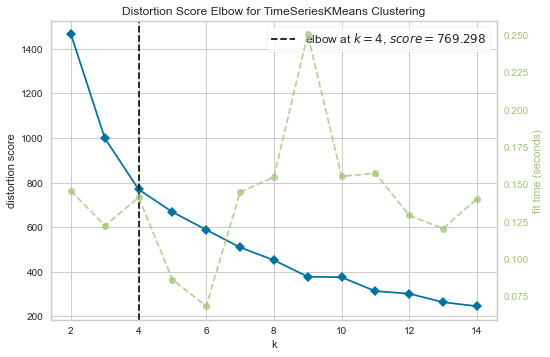

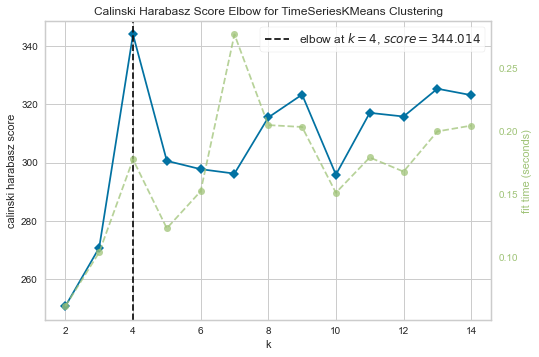

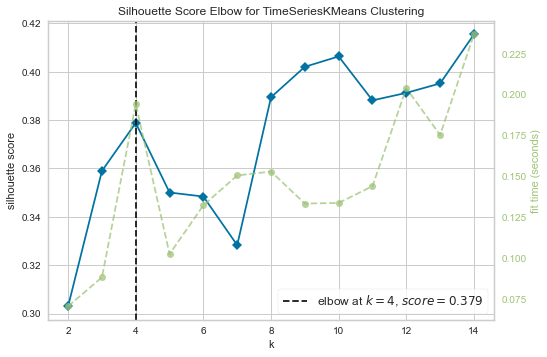

In [21]:
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer

liste_metrics = ['distortion', 'calinski_harabasz', 'silhouette']
#on teste la règle du coude avec trois métriques différentes : 
# distorsion = somme au carré des distances de chaque point à son centroïde
# calinski_harabasz = ratio entre la dispersion entre clusters et la dispersion dans le cluster
# silhouette = moyenne du ratio entre la distance au centroïde de son cluster et la distance au centroïde le plus proche

i=1
for metric in liste_metrics:
    model = TimeSeriesKMeans()
    visualizer = KElbowVisualizer(model, k=(2,15), metric=metric) 
    visualizer.fit(df_stand)       
    visualizer.show() 
i=+1

Les graphe ne sont pas incroyables. Est-ce que c'est vraiment pertinent de faire des clusters ???? 

In [22]:
#df_accord = df_accord.drop('cluster', axis =1)
import statistics
import tslearn
from tslearn.clustering import TimeSeriesKMeans


model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10)
Fit = model.fit(df_stand)

In [23]:
pred = Fit.labels_
df_stand['cluster'] = pred

In [24]:
df_cluster = df_stand

In [25]:
df_cluster_0 = df_cluster[df_cluster['cluster'].isin(['0'])]
df_cluster_1 = df_cluster[df_cluster['cluster'].isin(['1'])]
df_cluster_2 = df_cluster[df_cluster['cluster'].isin(['2'])]
df_cluster_3 = df_cluster[df_cluster['cluster'].isin(['3'])]

In [44]:
df_cluster_0
#df_cluster_1
#df_cluster_2
#df_cluster_3

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,cluster
idVotant,,,,,
PA721824,0.282769,-1.423359,-0.218255,1.358844,0
PA718802,0.998454,-1.077072,-0.919835,0.998454,0
PA719100,1.688143,-0.701696,-0.785846,-0.200601,0
PA719108,0.591237,-1.679276,0.198653,0.889386,0
PA719154,1.185135,-1.417976,-0.411639,0.644480,0
...,...,...,...,...,...
PA720006,0.000000,0.000000,0.000000,0.000000,0
PA643004,0.000000,0.000000,0.000000,0.000000,0
PA774958,0.000000,0.000000,0.000000,0.000000,0


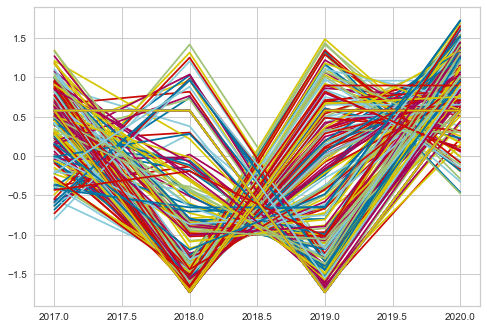

In [26]:
df_cluster_0 = df_cluster_0.drop('cluster', axis=1)
votants = df_cluster_0.index
for votant in votants:
    evolution = []
    date =list(df_cluster_0.columns)
    for annee in date : 
        evolution.append(df_cluster_0.loc[votant][annee])
    import matplotlib.pyplot as plt
    x = [2017, 2018, 2019, 2020]
    plt.plot(x, evolution)

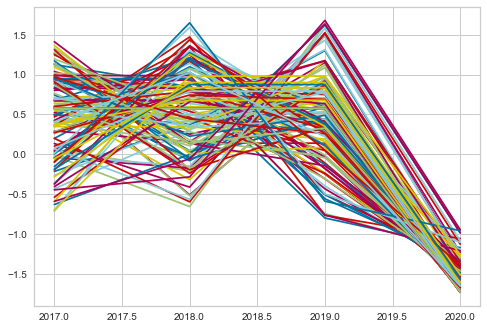

In [27]:
df_cluster_1 = df_cluster_1.drop('cluster', axis=1)
votants = df_cluster_1.index
for votant in votants:
    evolution = []
    date =list(df_cluster_1.columns)
    for annee in date : 
        evolution.append(df_cluster_1.loc[votant][annee])
    import matplotlib.pyplot as plt
    x = [2017, 2018, 2019, 2020]
    plt.plot(x, evolution)

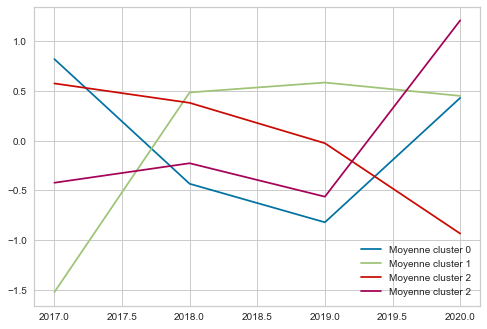

In [28]:
mean0 = []
for i in range(4):
    mean0.append(df_cluster_0[df_cluster_0.columns[3-i]].mean())
mean1 = []
for i in range(4):
    mean1.append(df_cluster_1[df_cluster_1.columns[3-i]].mean())
    
mean2 = []
for i in range(4):
    mean2.append(df_cluster_2[df_cluster_2.columns[3-i]].mean())
    
mean3 = []
for i in range(4):
    mean3.append(df_cluster_3[df_cluster_3.columns[3-i]].mean())

x = [2017, 2018, 2019, 2020]
plt.plot(x, mean0)
plt.plot(x, mean1)
plt.plot(x, mean2)
plt.plot(x, mean3)
label = ['Moyenne cluster 0', 'Moyenne cluster 1','Moyenne cluster 2','Moyenne cluster 3']
plt.legend(labels = label)

In [29]:
group = df_votes[['idVotant', 'Groupe politique (complet)']]
group = group.set_index('idVotant')

In [30]:
b = df_cluster.merge(group, on = "idVotant")

In [31]:
b = b.drop_duplicates()

In [32]:
b #544 députés ????? 

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,cluster,Groupe politique (complet)
idVotant,,,,,,
PA606171,-0.850860,-0.757246,-0.035475,1.643581,2,La République en Marche
PA721824,0.282769,-1.423359,-0.218255,1.358844,0,La République en Marche
PA719952,1.639672,-0.222676,-0.349366,-1.067630,3,La République en Marche
PA607395,0.842777,-0.081559,0.842777,-1.603995,1,La République en Marche
PA718710,-0.754918,-0.696742,1.698196,-0.246536,2,La République en Marche
...,...,...,...,...,...,...
PA774952,0.577350,0.577350,-1.732051,0.577350,0,Les Républicains
PA720006,0.000000,0.000000,0.000000,0.000000,2,Mouvement Démocrate (MoDem) et Démocrates appa...
PA643004,0.000000,0.000000,0.000000,0.000000,2,UDI et Indépendants


In [52]:
b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Socialistes et apparentés', 'UDI et Indépendants',
       'Libertés et Territoires', 'La France insoumise', 'Non inscrit',
       'Agir ensemble', 'Gauche démocrate et républicaine'], dtype=object)

In [53]:
b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains', 'Agir ensemble',
       'Libertés et Territoires', 'Non inscrit',
       'Socialistes et apparentés', 'Gauche démocrate et républicaine',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'UDI et Indépendants'], dtype=object)

In [54]:
b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains', 'Non inscrit',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Libertés et Territoires', 'Gauche démocrate et républicaine',
       'UDI et Indépendants', 'Socialistes et apparentés'], dtype=object)

In [55]:
b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains',
       'Socialistes et apparentés', 'Libertés et Territoires',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Gauche démocrate et républicaine', 'La France insoumise',
       'UDI et Indépendants', 'Non inscrit', 'Agir ensemble'],
      dtype=object)

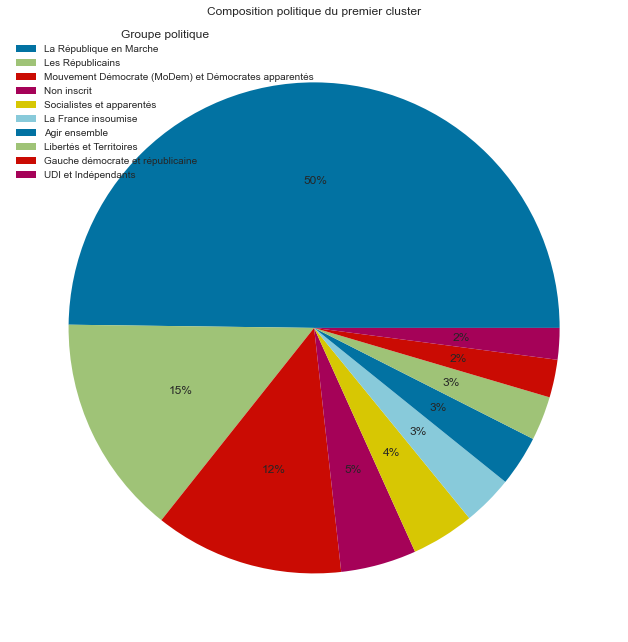

In [56]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du premier cluster")
labels = b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

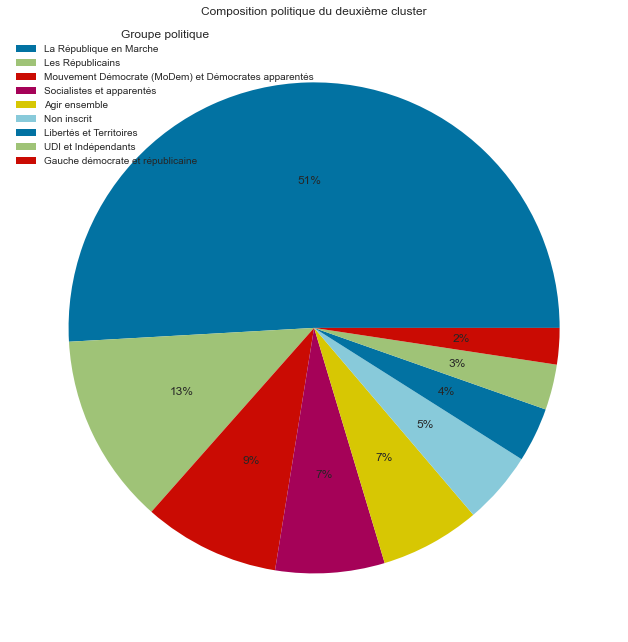

In [57]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du deuxième cluster")
labels = b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

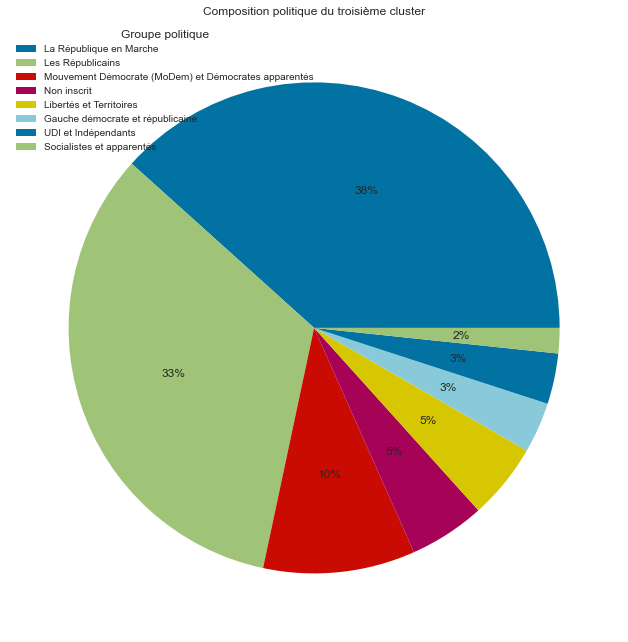

In [58]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du troisième cluster")
labels = b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

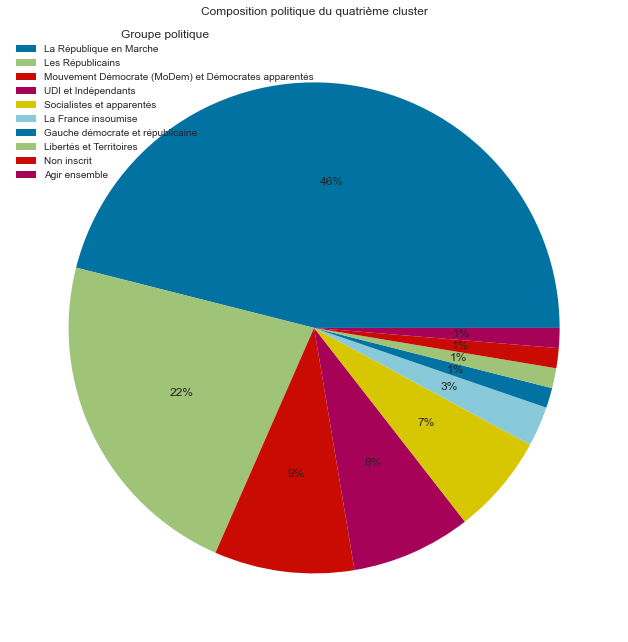

In [59]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du quatrième cluster")
labels = b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()